In [66]:
import numpy as np
import pandas as pd
import nltk, importlib, pickle

import utils.preprocessing as preprocessing
import clustering.wiki_graph as wiki_graph

from tqdm import tqdm

# Data Preprocessing

In this first part we will be Preprocessing text data to prepare them for clustering and classification. This will include the following steps:
* Noise Removal
* Normalization
* Tekenization & Segmentation 

## Data Loading

In [2]:
df = pd.read_pickle("data/dataset_business_technology_cybersecurity.pickle")
df = pd.DataFrame(df)
df.sample(5)

title                                            content  \
84           Partnership  <p>A <b>partnership</b> is an arrangement wher...   
219  Cable car (railway)  <p>A <b>cable car</b> (usually known as a <b>c...   
90     Benefit shortfall  <p>When the actual benefits of a venture are l...   
261       Computer virus  <p class="mw-empty-elt">\n\n</p>\n\n<p>A <b>co...   
101           Trade name  <p>A <b>trade name</b>, <b>trading name</b>, o...   

             topic  
84        business  
219     technology  
90        business  
261  cybersecurity  
101       business

In [3]:
# explore the data format in a txt file 
df.to_csv("data/backup_preprocess/content.txt")

## Noise Removal
Noise removal can be defined as text-specific normalization. As we are dealing with html row data, our data preprocessing pipeline will include striping away all HTML markup with the help of the BeautifulSoup library. We will also be replacing contractions with their expansions.

In [59]:
importlib.reload(preprocessing)
df["content"] = preprocessing.remove_noise_from_df(df["content"])
# backup saving
df.to_csv("data/backup_preprocess/content_without_noise.txt")

## Normalization
Normalization refers to a series of tasks that put all text on a level of playing field: converting all text to the same case(upper or lower), removing special characters(punctuation) and numbers, stemming, lemmatization, ... Normalization puts all words on equal footing and alows processing to proceed uniformly.

In [60]:
importlib.reload(preprocessing)
df["content"] = preprocessing.normalize_df(df["content"])
# backup save
df.to_csv("data/backup_preprocess/content_normalized.txt")

## Tockenization
 

In [61]:
importlib.reload(preprocessing)
df["content"] = df["content"].progress_apply(nltk.word_tokenize)
df.to_csv("data/backup_preprocess/content_tokenized.txt")
df.head(5)

# Part1: Clustering


In [2]:
df = pd.read_csv('data/backup_preprocess/content_tokenized.txt')
df.head(5)

Unnamed: 0                 title  \
0           0            Accounting   
1           1              Commerce   
2           2               Finance   
3           3  Industrial relations   
4           4            Management   

                                             content     topic  
0  ['account', 'account', 'measur', 'process', 'c...  business  
1  ['commerc', 'exchang', 'good', 'servic', 'espe...  business  
2  ['financ', 'term', 'matter', 'regard', 'manag'...  business  
3  ['industri', 'relat', 'employ', 'relat', 'mult...  business  
4  ['manag', 'manag', 'administr', 'organ', 'whet...  business

## A. Graph Clustering
### 1. Building a graph

In [62]:
importlib.reload(wiki_graph)
wiki_pages = df.to_dict(orient="records")
graph = wiki_graph.WikiGraph()
graph.build_graph(wiki_pages, constraint=20)

### 2. Time complexity of building the graph
Let $N$ be the number of wikipedia pages in the dataset.

If we don't consider preprocessing data as part of building the graph, we need to evaluate the time complexity of the following tasks:
* Create all the nodes of the graph: $O(N)$
* Connect all pairs of nodes that share at least n tokens: $O(k N^2)$

Given two nodes $(n1, n2)$ and their respective contents $(c1, c2)$ of length $(l1, l2)$, $n1$ and $n2$ share at least $n$ tokens if the length of the intersection of the sets (unique words) of their contents $(s1,s2)$ is greater or equal to $n$, that is $len(s1\cap s2)>=n$.

The time complexity of finding the intersection of two sets $(s1, s2)$ of respective length $(l1, l2)$ is $O(l1 + l2)$. Let $k=max(l1, l2)$, the time complexity of creating the edges of the graph is therefore $O(k N^2)$.

That is said, the overall time complexity of building a graph is $O(kN^2+N) = O(kN^2)$. 

### 3. Find the connected components of the graph

In graph theory, a connected component is a maximal connected subgrapgh of an undirected graph. each vertex belongs to exactly one connected cmponent, as does each edge. A graph is commected if and only if it has exactly one connected component.

In the following, we will be experimenting with different values of $n$: the min number of tokens in common. 

In [63]:
importlib.reload(wiki_graph)
n_tokens = list(range(5, 45, 2))
nb_clusters = {}
clusters = {}
for n in tqdm(n_tokens):
    graph = wiki_graph.WikiGraph()
    graph.build_graph(wiki_pages, constraint=n)
    clusters[n] = graph.get_wiki_clusters()
    nb_clusters[n] = len(clusters[n])

In [4]:
np.save("data/backup_preprocess/nb_clusters.npy", nb_clusters)
nb_clusters = np.load('data/backup_preprocess/nb_clusters.npy',allow_pickle='TRUE').item()

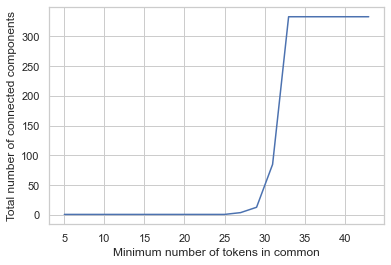

In [42]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.plot(nb_clusters.keys(), nb_clusters.values())
plt.ylabel('Total number of connected components')
plt.xlabel('Minimum number of tokens in common')
plt.savefig('data/images/n_cl_vs_n_tokens.png')

As we can see the optimal nb of clusters is between 25 and 30, let's check these values.

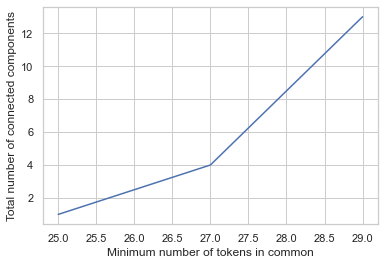

In [43]:
interesting_nb_clusters = {k:v for k, v in nb_clusters.items() if 25<=k<=30}
plt.plot(interesting_nb_clusters.keys(), interesting_nb_clusters.values())
plt.ylabel('Total number of connected components')
plt.xlabel('Minimum number of tokens in common')
plt.savefig('data/images/n_cl_vs_n_tokens_int.png')

Therefore, for all the following we will be using n=27 for the min number of tokens in common as it gives us 4 clusters which is close to our goal of 3 clusters.

In [64]:
graph = wiki_graph.WikiGraph()
graph.build_graph(wiki_pages, constraint=27)
clusters = graph.get_wiki_clusters()

### 4. Complexity of finding all components:
* ***Algorithm***: We will be using an iterative version (with a stack) of dfs (depth-first search) to find the connected components. 
* ***Time Complexity***: we will go through all the nodes of the graph with dfs, which gives $O(N)$ time Complexity.
* ***Space Complexity***: we need $O(N)$ extra space for dfs.
### 5. Title definition
We can determine a title as the most common topic of the cluster.
### 6. Let's explore an example
In the following we will define title for the 4th cluster (connected component) in the graph. this cluster contains only one wiki page and tehrefore it's topic is cybersecurity. 

In [33]:
print("Cluster nb 4 has title:", clusters[3].get_title())
print("This cluster contains", len(clusters[3].wiki_nodes), "wiki page")
print("With the following frequencies", clusters[3].get_topics_count())

Cluster nb 4 has title: cybersecurity
This cluster contains 1 wiki pages
With the following frequencies {'business': 0, 'cybersecurity': 1, 'technology': 0}


## B. End to End Pipeline
### 1. Efficient main
An efficient main to build the Pipeline can be find in the file ``main.py``
### 2. Pipeline Running
Please check the ``README.md`` file for running the Pipeline in experiment mode or backup mode.
### 3. Quality evaluation 

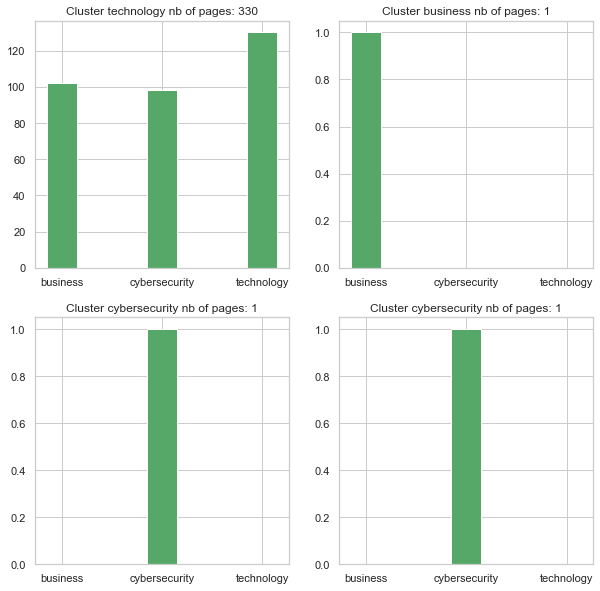

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, c in enumerate(clusters):
    topics_count = c.get_topics_count()
    axs[i//2, i%2].bar(topics_count.keys(), topics_count.values(), width=.3, color='g')
    axs[i//2, i%2].set_title(str(c))
fig.savefig('data/images/quality_eval.png')

As we can see in the figues above, most of the wikipedia are grouped in the first cluster that happened to contain all the articles of topic technology. Altough the resulting number of clusters approaches our goal of 3 clusters, their content is of poor quality as nearly all the wikipedia pages are grouped in the first cluster. The remaining clusters contain only one article which may contain a number of unique words smaller then the min number of tokens in common.

Let's display the number of unique words in theses clusters. 

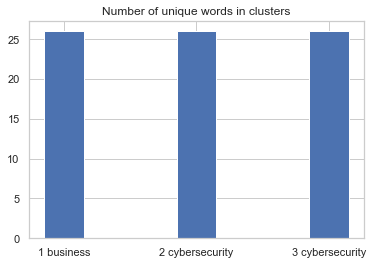

In [57]:
nb_unique_words = {}
for i, c in enumerate(clusters[1:]):
    nb_unique_words[str(i+1) + " " + c.get_title()] = len(c.wiki_nodes[0].wiki_page.content)
plt.bar(nb_unique_words.keys(), nb_unique_words.values(), width=.3, color='b')
plt.title('Number of unique words in clusters')
plt.savefig('data/images/nb_unique_words.png')

Indeed the number of unique words is $26<27$. If we choose $n-tokens < 26$ we get one connected component as all the nodes in the graph are connected. The constraint on the number of token sin common is therefore biased, we can improve it bu using a ratio $\frac{n-tokens-in-common}{n-total-tokens}$ for example and setting the constraint to be a percentage. (i.e two nodes are connected if 40% of their content is similar)
### 4. ML algorithm for clustering
In order to use Ml algortithm for clustering we will need to extand the preprocessing pipeline by adding a step for creating a DTF **Document Team Matrix** and another step for (TF-IDF) **Term Frequency-Inverse Document Frequency** that assigns weightage to each word depending on occurrence of a particular word in all the documents in the preprocessing pipeline. 

We can therefore use one of the following MLL algorithm for clustering: 

- Centroid-based Clustering: **K-means, KMedoids**
- Density-based Clustering: **DBSCAN**
- Hierarchical Clustering: **Hierarchical Clustering**
- Graph-Theory-based Clustering: **MST**                                                      
- Distribution-based Clustering: **EM (expecation maximisation) with GMM (gaussian mixtures models)**


I believe that K-means or any of these algorithms can give much better results.

### 5. Repeatability
In order to ensure the quality of the code, a set of unit test has been defined. 

Please check ``README.md`` file to be able to reproduce the results with a python script.

# Part2: Classification

In [2]:
df = pd.read_csv("data/backup_preprocess/content_normalized.txt")
df.drop(columns="Unnamed: 0", inplace = True)
df.head(5)

title                                            content  \
0            Accounting  account account measur process commun financi ...   
1              Commerce  commerc exchang good servic especi larg scale ...   
2               Finance  financ term matter regard manag creation studi...   
3  Industrial relations  industri relat employ relat multidisciplinari ...   
4            Management  manag manag administr organ whether busi notfo...   

      topic  
0  business  
1  business  
2  business  
3  business  
4  business

## Exploratory Data analysis
For the plots I have used seaborn and altair. altair is a package which allows to plot graphics with a simple grammar. It also provides easy-to-make interactive plots. For further information please visit the project site: https://altair-viz.github.io/.

To install it, please type this command in the shell:

```
! conda install -c conda-forge altair vega_datasets notebook vega
```

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

### Number of articles in each topic

In [64]:
bars = alt.Chart(df).mark_bar(size=50).encode(
    x=alt.X("topic"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of Wikipedia articles')),
    tooltip=[alt.Tooltip('count()', title='Number of Wikipedia articles'), 'topic'],
    color='topic'
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "Number of wikipedia articles in each topic",
)

alt.LayerChart(...)

### % of articles in each topic

In [101]:
df['id'] = 1
df2 = pd.DataFrame(df.groupby('topic').count()['id']).reset_index()

bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('topic'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Articles')),
    color='topic'
).transform_window(
    TotalArticles='sum(id)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.id / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "% of articles in each topic",
)


alt.LayerChart(...)

In [102]:
#remove the extra column used for counts
df.drop(columns='id', inplace=True)

The data seem to be quiet balanced w.r.t topics with 130 technology wikipages, 103 business wikipages and 100 cybersecurity wikipages 
## Content length by topic

In [74]:
df['content_length'] = df['content'].str.len()

Text(0.5, 1.0, 'Content length distribution')

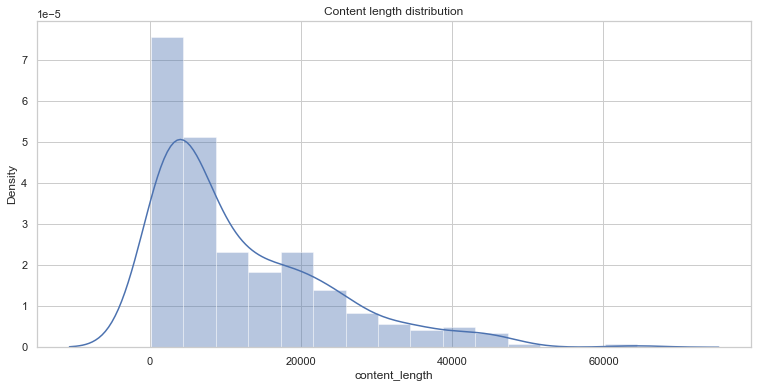

In [77]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['content_length']).set_title('Content length distribution')

In [78]:
df['content_length'].describe()

count      333.000000
mean     12101.507508
std      11488.264025
min        177.000000
25%       3090.000000
50%       7517.000000
75%      18618.000000
max      64459.000000
Name: content_length, dtype: float64

In [85]:
# Let's keep only data below the 90% percentile for better visualization without outliers 
quantile_95 = df['content_length'].quantile(0.95)
df_95 = df[df['content_length'] < quantile_95]

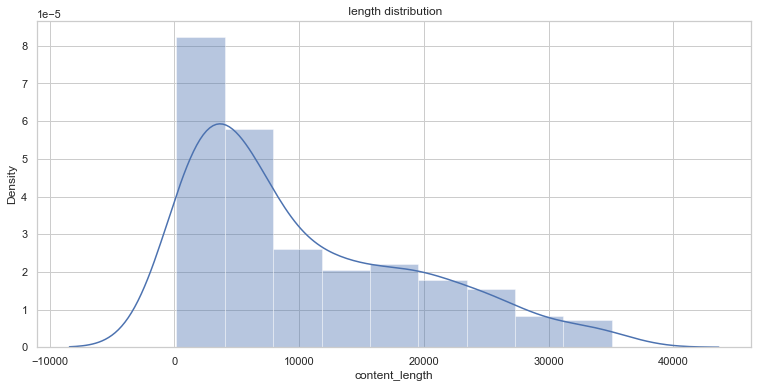

In [86]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['content_length']).set_title(' length distribution');

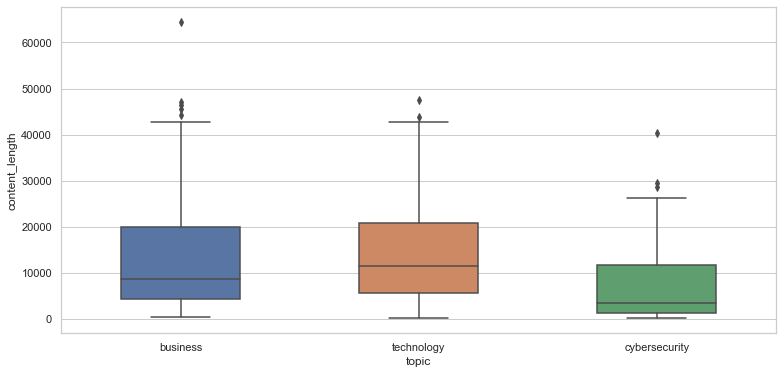

In [79]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='topic', y='content_length', width=.5);

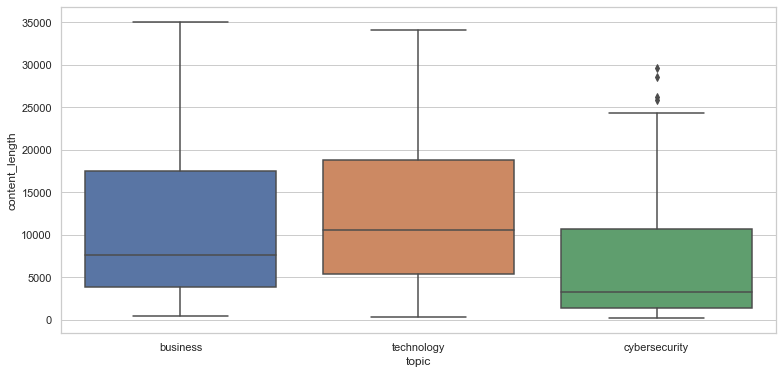

In [87]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='topic', y='content_length');

We can see that, although the length distribution is different for every topic, the difference is not too big. If we had way too different lengths between topics we would have a problem since the feature creation process may take into account counts of words. However, when creating the features with TF-IDF scoring, we will normalize the features just to avoid this.

In [46]:
X, y = df.drop(columns='topic'), df['topic']
X.head(5)

title                                            content
0            Accounting  account account measur process commun financi ...
1              Commerce  commerc exchang good servic especi larg scale ...
2               Finance  financ term matter regard manag creation studi...
3  Industrial relations  industri relat employ relat multidisciplinari ...
4            Management  manag manag administr organ whether busi notfo...

## Feature Engineering
The next step is to create features from the raw text so we can train the machine learning models. The steps followed are:

* Text Cleaning and Preparation: We have already completed this step in the first part of the challenge.
* Label coding: creation of a dictionary to map each category to a code.
* Train-test split: to test the models on unseen data.
* Text representation: use of TF-IDF scores to represent text.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt 

### Label Coding

In [4]:
topic_codes = {
    'business': 0,
    'technology': 1,
    'cybersecurity': 2,
}

In [6]:
# Category mapping
df['topic_code'] = df['topic']
df = df.replace({'topic_code':topic_codes})
df.sample(5)

title  \
11             Big business   
263           Eavesdropping   
192                     Bus   
227  Track (rail transport)   
248              Dual-homed   

                                               content          topic  \
11   big busi involv largescal corporatecontrol fin...       business   
263  eavesdrop act secretli stealthili listen priva...  cybersecurity   
192  bu contract omnibu variant multibu motorbu aut...     technology   
227  track railway railroad also know perman way st...     technology   
248  dualhom dualhom refer either ethernet devic on...  cybersecurity   

     topic_code  
11            0  
263           2  
192           1  
227           1  
248           2

### Train - test split
We'll set apart a test set to prove the quality of our models. We'll do Cross Validation in the train set in order to tune the hyperparameters and then test performance on the unseen data of the test set.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['content'], 
                                                    df['topic_code'], 
                                                    test_size=0.15, 
                                                    random_state=8)

### Text Representation

We have various options:

* Count Vectors as features
* TF-IDF Vectors as features
* Word Embeddings as features
* Text / NLP based features
* Topic Models as features

We'll use TF-IDF Vectors as features.

We have to define the different parameters:

* ``ngram_range``: We want to consider both unigrams and bigrams.
* ``max_df=0.7``: Similarly, this parameter corresponds to the maximum number of documents that should contain this feature. 0.7 corresponds to a percentage that means we should include only those words that occur in a maximum of 70%
* ``min_df=5``: This parameter corresponds to the minimum number of documents that should contain this feature.
* ``max_features=1500``: When we convert words to numbers using the bag of words approach, all the unique words in all the documents are converted into features. All the documents can contain tens of thousands of unique words. But the words that have a very low frequency of occurrence are unusually not a good parameter for classifying documents. Therefore we set the ``max_features`` parameter to 1500, which means that we want to use 1500 most occurring words as features for training our classifier.

In [8]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 0.7
max_features = 1500

In [9]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

# we only transform the test set
features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(283, 1500)
(50, 1500)


### Feature selection

We will use the Chi squared test in order to see what unigrams and bigrams are most correlated with each topic.

In [113]:
from sklearn.feature_selection import chi2
import numpy as np

for topic, topic_id in sorted(topic_codes.items()):
    features_chi2 = chi2(features_train, labels_train == topic_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' topic:".format(topic))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'business' topic:
  . Most correlated unigrams:
. profit
. economist
. sharehold
. trade
. busi
  . Most correlated bigrams:
. strateg plan
. product servic

# 'cybersecurity' topic:
  . Most correlated unigrams:
. malici
. vulner
. firewal
. attack
. secur
  . Most correlated bigrams:
. access control
. inform secur

# 'technology' topic:
  . Most correlated unigrams:
. railway
. secur
. passeng
. rail
. electr
  . Most correlated bigrams:
. inform secur
. electr power



As we can see, both the unigrams and bigrams correspond well to their topics.

## Building ML Modles

Now that we have our feature vectors built, we'll try several machine learning classification models in order to find which one performs best on wikipedia articles data. We will try with the following models:

* Random Forest
* Support Vector Machine
* Gradient Boosting
* K Nearest Neighbors
* Multinomial Naïve Bayes
* Multinomial Logistic Regression


# Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


## Hyperparameter tuning
### Randomized Search Cross Validation 
We will first start with a randomized search to indentify hyperparameters regions in which we get higher values of accuracy.

In [118]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [119]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs=-1)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, scoring='accuracy', verbose=1)

In [15]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.5}

The mean accuracy of a model with these hyperparameters is:
0.9505039193729004


### Grid Search Cross Validation 
Now that we know approxiametly the region that gives the best accuracy.

In [121]:
bootstrap = [False]
max_depth = [None]
max_features = ['auto']
min_samples_leaf = [1, 2, 4]
min_samples_split = [3 ,5, 10]
n_estimators = [600]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1,
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   35.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=RandomForestClassifier(random_state=8),
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [600]},
             scoring='accuracy', verbose=1)

In [122]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 600}

The mean accuracy of a model with these hyperparameters is:
0.9574468085106383


In [123]:
best_rfc = grid_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=600,
                       random_state=8)

## Model Performance Evaluation 

In [125]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=600,
                       random_state=8)

In [126]:
rfc_pred = best_rfc.predict(features_test)
# We can also retrieve the conditional probabilities with best_rfc.predict_proba(features_test)

### Training accuracy

In [127]:
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
1.0


### Test accuracy

In [128]:
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.9


### Classification Report

In [129]:
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.83      0.94      0.88        16
           2       0.95      0.86      0.90        21

    accuracy                           0.90        50
   macro avg       0.90      0.91      0.90        50
weighted avg       0.90      0.90      0.90        50



We get pretty descent result with an accuracy of 90% and an avg precision of 90%. Let's see which metric is the most important from a customer point of view.
* Precision talks about how precise/accurate a model is. Precision is a good measure to determine, when the costs of False Positive is high. For instance, email spam detection.
* Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). 
For instance, in fraud detection or sick patient detection. If a fraudulent transaction (Actual Positive) is predicted as non-fraudulent (Predicted Negative), the consequence can be very bad for the bank.
* F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

Therefore we could use F1-score as a metric as we want to sick a balance between Precision and Recall.    
### Confusion Matrix

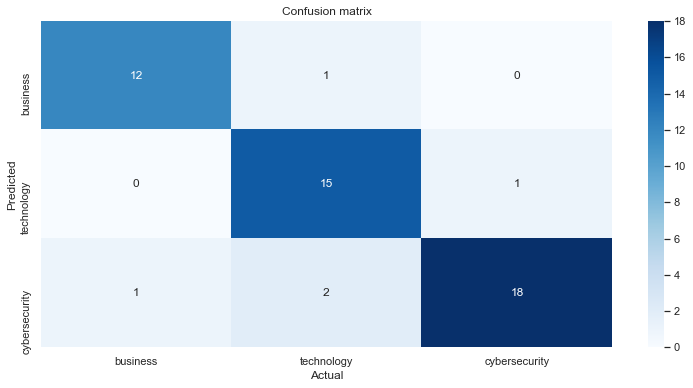

In [132]:
aux_df = df[['topic', 'topic_code']].drop_duplicates().sort_values('topic_code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['topic'].values, 
            yticklabels=aux_df['topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [136]:
with open('Models/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)

# Support Vector Machines

In [139]:
from sklearn import svm
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


## Hyperparameter tuning
### Randomized Search Cross Validation

In [142]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [143]:
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs=-1)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.3min finished


RandomizedSearchCV(cv=3, estimator=SVC(random_state=8), n_iter=50,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   random_state=8, scoring='accuracy', verbose=1)

In [144]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.7771183277342292


### Grid Search Cross Validation

In [148]:
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1,
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   36.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=SVC(random_state=8),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability': [True]}],
             scoring='accuracy', verbose=1)

In [149]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.0001, 'degree': 3, 'kernel': 'poly', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.40425531914893614


As grid search didn't improve the accuracy of the model we will keep the results of random search.

In [151]:
best_svc = random_search.best_estimator_
best_svc

SVC(C=0.01, degree=4, gamma=10, kernel='poly', probability=True, random_state=8)

## Model Performance Evaluation 

In [152]:
best_svc.fit(features_train, labels_train)

SVC(C=0.01, degree=4, gamma=10, kernel='poly', probability=True, random_state=8)

In [153]:
svc_pred = best_svc.predict(features_test)

### Training accuracy

In [154]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
1.0


### Classification report

In [155]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.70      1.00      0.82        16
           2       1.00      0.71      0.83        21

    accuracy                           0.84        50
   macro avg       0.87      0.85      0.84        50
weighted avg       0.88      0.84      0.84        50



We get an F1-Score of 84% which is not bad but we we maanged to get better result with random forests. 
### Confusion matrix

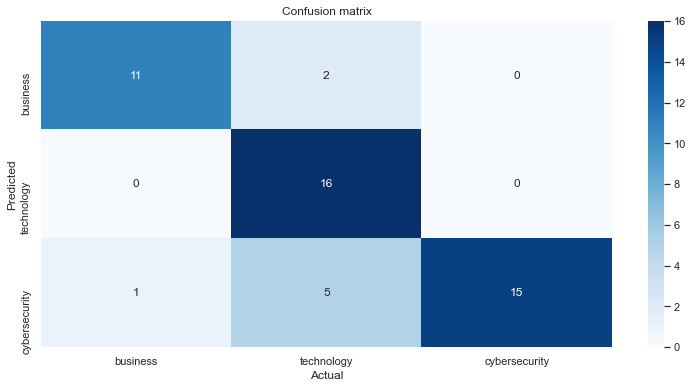

In [156]:
aux_df = df[['topic', 'topic_code']].drop_duplicates().sort_values('topic_code')
conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['topic'].values, 
            yticklabels=aux_df['topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [157]:
with open('Models/best_svc.pickle', 'wb') as output:
    pickle.dump(best_svc, output)

# Gradient Boosting Machine

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
gb_0 = GradientBoostingClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(gb_0.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 8,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


## Hyperparameter tuning
### Randomized Search Cross Validation

In [13]:
# n_estimators
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


In [14]:
# First create the base model to tune
gbc = GradientBoostingClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=gbc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs=-1)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 20.5min finished


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=8),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.5],
                                        'max_depth': [10, 40, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [10, 30, 50],
                                        'n_estimators': [200, 800],
                                        'subsample': [0.5, 1.0]},
                   random_state=8, scoring='accuracy', verbose=1)

In [16]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.5}

The mean accuracy of a model with these hyperparameters is:
0.9505039193729004


## Grid Search Cross Validation

In [17]:
max_depth = [5, 10, 15]
max_features = ['sqrt']
min_samples_leaf = [1]
min_samples_split = [50, 100]
n_estimators = [200]
learning_rate = [.3, .5]
subsample = [1.]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
gbc = GradientBoostingClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1, 
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   14.2s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=GradientBoostingClassifier(random_state=8), n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.5], 'max_depth': [5, 10, 15],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [50, 100], 'n_estimators': [200],
                         'subsample': [1.0]},
             scoring='accuracy', verbose=1)

In [18]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'learning_rate': 0.3, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50, 'n_estimators': 200, 'subsample': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.9787234042553191


In [19]:
best_gbc = grid_search.best_estimator_
best_gbc

GradientBoostingClassifier(learning_rate=0.3, max_depth=5, max_features='sqrt',
                           min_samples_split=50, n_estimators=200,
                           random_state=8)

## Model Performance Evaluation 

In [20]:
best_gbc.fit(features_train, labels_train)

GradientBoostingClassifier(learning_rate=0.3, max_depth=5, max_features='sqrt',
                           min_samples_split=50, n_estimators=200,
                           random_state=8)

In [21]:
gbc_pred = best_gbc.predict(features_test)

### Training accuracy

In [22]:
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_gbc.predict(features_train)))

The training accuracy is: 
1.0


### Test accuracy

In [23]:
print("The test accuracy is: ")
print(accuracy_score(labels_test, gbc_pred))

The test accuracy is: 
0.88


### Classification report 


In [24]:
# Classification report
print("Classification report")
print(classification_report(labels_test,gbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.82      0.88      0.85        16
           2       0.95      0.86      0.90        21

    accuracy                           0.88        50
   macro avg       0.88      0.89      0.88        50
weighted avg       0.88      0.88      0.88        50



### Confusion matrix

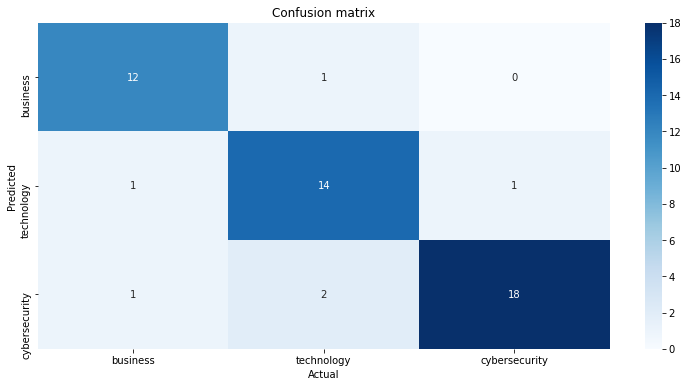

In [28]:
import seaborn as sns
aux_df = df[['topic', 'topic_code']].drop_duplicates().sort_values('topic_code')
conf_matrix = confusion_matrix(labels_test, gbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['topic'].values, 
            yticklabels=aux_df['topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [29]:
with open('Models/best_gbc.pickle', 'wb') as output:
    pickle.dump(best_gbc, output)

# Multinomial Naive Bayes
we won't be tuning any hyperparameter for naive bayer classifie

In [30]:
from sklearn.naive_bayes import MultinomialNB
mnbc = MultinomialNB()
mnbc.fit(features_train, labels_train)

MultinomialNB()

## Model Performance and Evaluation

In [31]:
mnbc_pred = mnbc.predict(features_test)

In [32]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, mnbc.predict(features_train)))

The training accuracy is: 
0.950530035335689


In [33]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, mnbc_pred))

The test accuracy is: 
0.82


In [34]:
print("Classification report")
print(classification_report(labels_test,mnbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.74      0.88      0.80        16
           2       0.94      0.76      0.84        21

    accuracy                           0.82        50
   macro avg       0.82      0.83      0.82        50
weighted avg       0.84      0.82      0.82        50



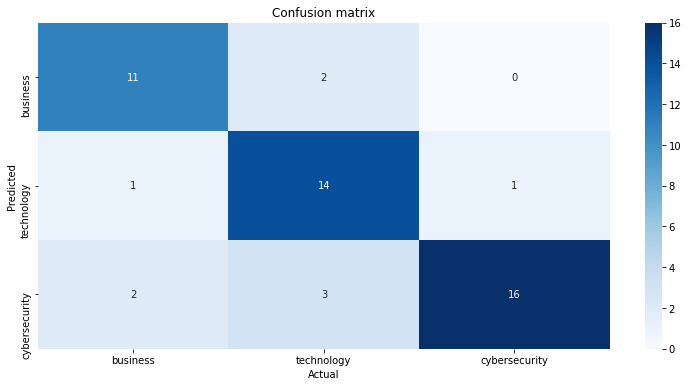

In [35]:
aux_df = df[['topic', 'topic_code']].drop_duplicates().sort_values('topic_code')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['topic'].values, 
            yticklabels=aux_df['topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [36]:
with open('Models/best_mnbc.pickle', 'wb') as output:
    pickle.dump(mnbc, output)

# Multinomial Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


## Hyperparameter tuning
### Randomized Search Cross Validation

In [38]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [39]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs=-1)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.1s finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=8),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': ['balanced', None],
                                        'multi_class': ['multinomial'],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']},
                   random_state=8, scoring='accuracy', verbose=1)

In [40]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': None, 'C': 0.6}

The mean accuracy of a model with these hyperparameters is:
0.9363195222097799


## Grid Search cross validation

In [41]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1, 
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=LogisticRegression(random_state=8), n_jobs=-1,
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
                         'class_weight': ['balanced'],
                         'multi_class': ['multinomial'], 'penalty': ['l2'],
                         'solver': ['sag']},
             scoring='accuracy', verbose=1)

In [42]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 1.0, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.9574468085106383


In [43]:
best_lrc = grid_search.best_estimator_
best_lrc

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=8, solver='sag')

## Model Performance and Evaluation

In [44]:
best_lrc.fit(features_train, labels_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=8, solver='sag')

In [45]:
lrc_pred = best_lrc.predict(features_test)

In [46]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

The training accuracy is: 
1.0


In [47]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The test accuracy is: 
0.88


In [48]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.79      0.94      0.86        16
           2       0.94      0.81      0.87        21

    accuracy                           0.88        50
   macro avg       0.89      0.89      0.88        50
weighted avg       0.89      0.88      0.88        50



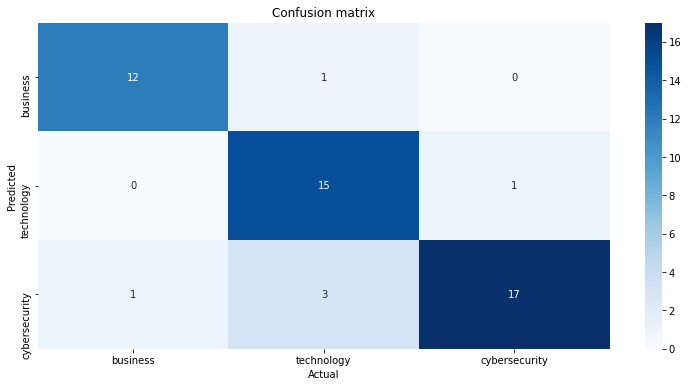

In [49]:
aux_df = df[['topic', 'topic_code']].drop_duplicates().sort_values('topic_code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['topic'].values, 
            yticklabels=aux_df['topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [50]:
with open('Models/best_lrc.pickle', 'wb') as output:
    pickle.dump(best_lrc, output)

# K nearest Neighbors

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knnc_0 =KNeighborsClassifier()

print('Parameters currently in use:\n')
pprint(knnc_0.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


## Hyperparameter tuning
As we only have one Hyperparameter we will do a grip search directly
### Grid Search Cross Validation

In [53]:
# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 50, num = 100)]

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1,
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6,
                                         7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12,
                                         12, 13, 13, 14, 14, 15, ...]},
             scoring='accuracy', verbose=1)

In [54]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 7}

The mean accuracy of a model with these hyperparameters is:
0.9503546099290782


In [55]:
n_neighbors = [1,2,3,4,5,6,7,8,9,10,11]
param_grid = {'n_neighbors': n_neighbors}

knnc = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  33 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             scoring='accuracy', verbose=1)

In [56]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 7}

The mean accuracy of a model with these hyperparameters is:
0.9503546099290782


In [57]:
best_knnc = grid_search.best_estimator_
best_knnc

KNeighborsClassifier(n_neighbors=7)

## Model Evaluation

In [58]:
best_knnc.fit(features_train, labels_train)

KNeighborsClassifier(n_neighbors=7)

In [60]:
knnc_pred = best_knnc.predict(features_test)

In [61]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_knnc.predict(features_train)))

The training accuracy is: 
0.9540636042402827


In [62]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, knnc_pred))

The test accuracy is: 
0.86


In [63]:
# Classification report
print("Classification report")
print(classification_report(labels_test,knnc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.79      0.94      0.86        16
           2       1.00      0.76      0.86        21

    accuracy                           0.86        50
   macro avg       0.86      0.87      0.86        50
weighted avg       0.88      0.86      0.86        50



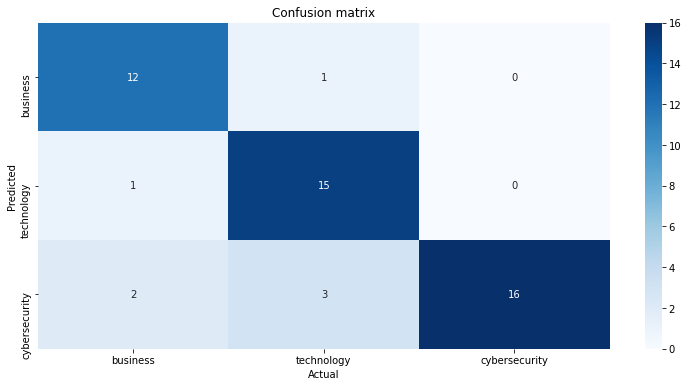

In [64]:
# Confusion matrix
aux_df = df[['topic', 'topic_code']].drop_duplicates().sort_values('topic_code')
conf_matrix = confusion_matrix(labels_test, knnc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['topic'].values, 
            yticklabels=aux_df['topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [65]:
with open('Models/best_knnc.pickle', 'wb') as output:
    pickle.dump(best_knnc, output)

# Conclusion
Based on the F1-score, it seems like random forests are the best classifier for this task with an F1-score of 90% vs 86% for Knn, 88% Multinomial Logistic Regression, 88% for Gradient Boosting, 84% for Support Vector Machines and finally 82% for Multinomial Naive Bayes.

Given the results of this investigation , I would decide de deploy the Random forests classifier into production.